# TP14 : Détection de contour
Le but de ce TP est de détecter un contour dans une image en utilisant l'algorithme de Dijkstra. L'idée est que l'utilisateur doit désigner deux pixels dans une image et l'algorithme doit trouver un contour qui permet de relier ces deux points.

Pour plus de simplicité, on se limite à des images en niveaux de gris, ainsi chaque pixel de l'image est identifié avec un entier entre 0 et 255 qui représente son niveau de gris.

Pour rappel, l'algorithme de Dijkstra permet, dans un graphes à poids positisf ou nuls, de calculer les chemins de poids minimal d'un sommet donné vers tous les autres sommets du graphe.

Je remets les fonctions permettant de lire une image dans un fichier et d'afficher l'image dans le notebook:

In [1]:
from PIL import Image

def img2array(fic):
    """fic est le nom d'un fichier contenant une image
    la fonction renvoie une liste de listes d'entiers représentants des niveaux de gris"""
    im = Image.open(fic).convert('L')  ## chargement et passage en niveaux de gris
    tab = [ [0 for _ in range(im.height)] for _ in range(im.width)]
    i = 0
    j = -1
    for c in im.getdata():
        if i % im.width == 0: ## debut d'une nouvelle ligne dans l'image
            i = 0
            j += 1
        tab[i][j] = c
        i += 1
    im.close()
    return tab

In [2]:
from PIL import Image
from IPython.display import display

def affiche_image(img):
    """img : image sous forme d'une liste de listes de niveaux de gris
    affichage de l'image"""
    im = Image.new(size=(len(img), len(img[0])), mode='L')
    for i in range(len(img)):
        for j in range(len(img[i])):
            im.putpixel((i, j), img[i][j])
    display(im)

### Un graphe à partir d'une image
Une image est un tableau bidimensionnel de pixels. Ainsi à toute image on peut associer un graphe non orienté dont les sommets sont les pixels de l'image et tel que deux sommets sont adjacents si et seulement si les pixels correspondants sont voisins dans l'image. En dehors des sommets représentant des pixels sur le bord de l'image, chaque sommet possède donc 8 voisins.

Une _ligne_ sur une image est une suite de pixels voisins. Cette notion correspond donc à celle de chemin dans le graphe associé à l'image.

Intuitivement, un contour dans une image représente une suite de pixels qui sont entourés à peu près des mêmes couleurs (ou des mêmes intensités lumineuses dans le cas d'une image en noir et blanc).

## Mise en place des poids des arêtes
Pour que le chemin de poids minimal entre deux sommets représente un contour, il faut bien choisir les poids sur les arêtes du graphe. Nous allons prendre les poids suggérés par l'article _[Intelligent scissors for image composition](https://dl.acm.org/doi/10.1145/218380.218442)_ de Eric N. Mortensen et William A. Barrett.

Pour calculer ces poids, il faut utiliser l'opération de convolution sur des matrices.

Si on identifie une image avec une matrice d'entiers 
$$M=(m_{i,j})_{\genfrac{}{}{0pt}{}{0\leq i< H}{0\leq j< L}}\:,$$
on peut lui appliquer un filtre
$$F = (f_{i, j})_{\genfrac{}{}{0pt}{}{-I\leq i\leq I}{-I\leq j\leq I}}$$
par _produit de convolution_ : $M\star F$ est une matrice
$H\times L$ dont les coefficients sont donnés par:
$$(M\star F)_{k,\ell} = \sum_{i=-I}^{I}\sum_{j=-I}^{I} m_{k+i, \ell+j}\times
f_{i, j}\:.$$
(Bien sûr on se limite aux coefficients qui ont un sens dans la somme ci-dessus. En général $I$ est nettement plus petit que $H$ et $L$, cette limitation ne concerne donc qu'un mince bord de l'image.)

### Exercice 1: produit de convolution
Écrire une fonction `convolution` qui prend en argument une matrice et un filtre et renvoie le produit de convolution des deux. (À noter que dans la vraie vie, on utilise une transformée de Fourier rapide pour cette opération, ce qui permet de gagner deux ordres de grandeur en complexité; ici nous ferons le calcul naïvement et cela explique la lenteur sur de vraies images.)

In [4]:
F = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
M = [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]
assert(convolution(M, F) == M)

F = [[-1,0,1], [1,0,-1], [0,1,-1]]
assert(convolution(M, F) == [[-3, -3, -9, 3], [-5, -1, -14, 2], [-5, -1, -6, 2]])

### Laplacien
Le _laplacien_ est un opérateur qui mesure la différence entre l'intensité lumineuse d'un pixel et la valeur moyenne des intensités lumineuses des pixels autour.
Il peut être approché en convoluant l'image avec le filtre

In [5]:
Laplacien = [
    [-1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1],
    [-1, -1, 24, -1, -1],
    [-1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1]
]

On note $\Delta M$ la matrice ainsi obtenue : $\Delta M = M\star L$.

### Gradient
Le _gradient_ est une généralisation vectorielle de la dérivée. La dérivée d'une fonction définie sur ${\mathbb R}$ (c'est-à-dire une ligne) nous donne des renseignements sur les variations de cette fonction, le gradient nous donne des renseignements sur les variations d'une fonction définie sur un plan. On peut considérer qu'une image en niveaux de gris est une fonction qui à chaque point associe comme valeur l'intensité lumineuse de ce point.

Le gradient est dirigé perpendiculairement aux lignes de niveaux, vers les valeurs croissantes.

La composante horizontale (suivant l'axe des abscisses) du gradient peut être approchée par une convolution avec le filtre

In [39]:
Gx = [
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
]

La composante verticale (suivant l'axe des ordonnées) du gradient peut être approchée par une convolution avec le filtre transposé.

In [40]:
Gy = [
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
]

On note $$\vec\nabla M = (M\star G_x, M\star G_y)$$ le gradient de $M$. En un point $P=(i,j)$, le gradient $\vec\nabla M_{P}$ est le vecteur de coordonnées $((M\star G_x)_{i,j}, (M\star G_y)_{i,j})$.

La norme de $\vec\nabla M_{P}$ est notée $\nabla M_{P}$.

Pour accélerer les calculs, au lieu de transmettre une matrice de fonction en fonction, on va transmettre les valeurs liées au laplacien et au gradient de l'image.

Dans toutes les fonctions qui suivent, les paramètres qui apparaissent sont les suivants, si `M` est la matrice associée à une image:
* `laplM`: laplacien de `M`
* `gradMx` : composante horizontale du gradient de `M`
* `gradMy` : composante vertitale du gradient de `M`
* `gradMax` : maximum des normes des gradients de `M`
* `P`, `Q` : points (sous le forme de couples d'entiers)

### Exercice 2 : gradient
1. Écrire une fonction `gradient` qui prend en argument une matrice $M$ et renvoie le couple $(M\star G_x, M\star G_y)$.

In [9]:
M = [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]
gradMx, gradMy = gradient(M)
assert((gradMx[0][0], gradMy[0][0]) == (-10/4, -16/4))
assert((gradMx[2][3], gradMy[2][3]) == (4/4, 16/4))

2. Écrire une fonction `norme` qui prend en argument un couple d'entiers représentant un vecteur et renvoie sa norme.

In [11]:
import math
epsilon = .000001
assert(math.fabs(norme((0,0))) < epsilon)
assert(math.fabs(norme((4,7)) - 8.06225774829855) < epsilon)
assert(math.fabs(norme((-5,8)) - 9.433981132056603) < epsilon)

Le poids d'une arête de $P$ vers $Q$ est donné par la somme de trois termes pour lesquels nous allons écrire des fonctions petit à petit:
$$0.43f_Z(Q) + 0.43f_G(Q) + 0.14f_D(P, Q)\:,$$

où:
* $f_Z$ est définie par
$$f_Z(Q)=\begin{cases}
0 & \text{si }\Delta M_{Q}\text{ est proche de }0,\\
1 & \text{sinon.}
\end{cases}$$

#### calcul de $f_Z$
Voici une fonction `fZ` qui prend en argument le laplacien d'une matrice et un point (sous la forme d'un couple de coordonnées), et renvoie la valeur de $f_Z$ pour ce point.

In [41]:
def fZ(laplM, Q):
    return 0 if laplM[Q[0]][Q[1]] < 0.00001 else 1

* $f_G$ est définie par
$$f_G(Q) = 1-\frac{\nabla M_{Q}}{\nabla_{\max}}\:,$$
 où
  $\nabla_{\max}$ désigne le maximum de la norme du gradient sur
  tous les points de l'image.

### Exercice 4 : calcul de $f_G$
1. Écrire une fonction `grad_max` qui prend en argument la composante horizontale et la composante verticale du gradient d'une matrice, et renvoie le maximum de la norme du gradient sur tous les points de l'image correspondante.

In [44]:
import math
epsilon = 0.000001
M = [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]
gradMx, gradMy = gradient(M)
assert(math.fabs(grad_max(gradMx, gradMy) - 48.82622246293481) < epsilon)

2. Écrire une fonction `fG(gradMx, gradMy, gradMax, Q)` qui renvoie la valeur de $f_G$ pour le point `Q`.

In [46]:
import math
epsilon = 0.000001
M = [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]
gradMx, gradMy = gradient(M)
gradMax = grad_max(gradMx, gradMy)
assert(math.fabs(fG(gradMx, gradMy, gradMax, (2,1)) - 0.6336283472763441) < epsilon)

* et $f_D$ est définie par
$$f_D(P, Q) = \frac{2}{3\pi}\bigl(\arccos{d_{P}(P, Q)} +
  \arccos{d_{Q} (P, Q)}\bigr)\:,$$ où
$$d_{X}(P,Q) = D(X)\cdot L(P, Q)$$
est un produit scalaire entre le vecteur unitaire perpendiculaire au gradient (et donc colinéaire aux lignes de niveaux)
$$D(P) = \bigl(\frac{(\vec\nabla M_{P})_y}{\nabla M_{P}},
-\frac{(\vec\nabla M_{P})_x}{\nabla M_{P}}\bigr)$$ et  le
vecteur $\overrightarrow{PQ}$ ou $\overrightarrow{QP}$:
$$L(P,Q) = \begin{cases}
\overrightarrow{PQ} & \text{si }D(P)\cdot \overrightarrow{PQ}\geq 0.\\
\overrightarrow{QP} & \text{sinon.}
\end{cases}$$
Cette composante sert à évaluer l'écart entre la ligne de niveau
passant par $P$ et le vecteur $\overrightarrow{PQ}$: le
produit scalaire de la formule fait apparaître le cosinus de l'angle entre la ligne de niveau colinéaire à
$D(X)$ et le vecteur $\overrightarrow{PQ}$.

### Exercice 5 : calcul de $f_D$
Écrire une fonction `produit_scalaire` qui prend en argument deux listes de longueur 2 représentant des vecteurs et renvoie le produit scalaire de ces deux vecteurs.

In [48]:
assert(produit_scalaire((1,3),(-2,9)) == 25)

Voici une fonction `dX(gradMx, gradMy, P, Q, X)` qui renvoie la valeur de $d_X(P, Q)$ et la fonction `fD(gradMx, gradMy, P, Q)` qui renvoie la valeur de $f_D(P, Q)$.

In [51]:
import math

def dX(gradMx, gradMy, P, Q, X):
    epsilon = 0.000000001
    gradX = (gradMx[X[0]][X[1]], gradMy[X[0]][X[1]])
    norme_gradX = norme(gradX)
    if norme_gradX < epsilon:
        return 0
    DX = (gradX[1]/norme_gradX, -gradX[0]/norme_gradX)
    gradP = (gradMx[P[0]][P[1]], gradMy[P[0]][P[1]])
    DP = (gradP[1], -gradP[0])
    normePQ = norme((Q[0]-P[0], Q[1]-P[1]))
    LPQ = ((Q[0]-P[0])/normePQ, (Q[1]-P[1])/normePQ) if produit_scalaire(DP, [Q[0]-P[0], Q[1]-P[1]])>=0\
        else ((P[0]-Q[0])/normePQ, (P[1]-Q[1])/normePQ)
    return produit_scalaire(DX, LPQ)

def fD(gradMx, gradMy, P, Q):
    return 2/(3*math.pi)*(math.acos(dX(gradMx, gradMy, P, Q, P)) + math.pi - math.acos(dX(gradMx, gradMy, P, Q, Q)))

### Exercice 6 : poids d'une arête
Écrire une fonction `poids(laplM, gradMx, gradMy, gradMax, P, Q)` qui renvoie le poids de l'arête entre `P` et `Q`.

In [53]:
import math
epsilon = 0.0000001
M = [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]
laplM = convolution(M, Laplacien)
gradMx, gradMy = gradient(M)
gradMax = grad_max(gradMx, gradMy)
P = (1,2)
Q = (2,3)
assert(math.fabs(poids(laplM, gradMx, gradMy, gradMax, P, Q) - 0.7868442004809104) < epsilon)

## Interlude : file de priorité
Pour implémenter l'algorithme de Dijkstra, nous allons utiliser des files de priorité. Le module `heapq` fournit tout ce qu'il faut pour cela:

In [54]:
import heapq
#help(heapq)

Pour mettre un point $P$ avec une poids $p$, on peut utiliser un couple $(p, P)$ car les couples sont ordonnés en fonction de leurs premières composantes.

## Mise en place de l'algorithme de Dijkstra

### Exercice : liste de voisins
Écrire une fonction `voisins` qui prend en argument une matrice représentant une image (pour ses dimensions) et un point (sous la forme d'un couple d'entiers) et renvoie la liste des voisins du points dans l'image.

In [56]:
M = [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]
assert(voisins(M, (2,3)) == [(1, 2), (1, 3), (2, 2), (2, 4)])

### Exercice : algorithme de Dijkstra
Pour accélerer les calculs, au lieu de transmettre l'image, on va là encore transmettre les valeurs liées au laplacien et au gradient de l'image.

Dans toutes les fonctions qui suivent, les paramètres qui apparaissent sont les suivants, si `M` est la matrice associée à une image:
* `laplM`: laplacien de `M`
* `gradMx` : composante horizontale du gradient de `M`
* `gradMy` : composante vertitale du gradient de `M`
* `gradMax` : maximum des gradients de `M`
* `P`, `Q` : points (sous le forme de couples d'entiers)
* `dist` : tableau des distances calculées
* `pred` : tableau des prédécesseurs calculés
* `file` : file d'attente



1. Écrire une fonction initialisation qui prend en argument une matrice représentant une image et renvoie un couple de deux tableaux bidimensionnels de mêmes dimensions que l'image, le premier contenant des `math.inf` dans toutes ses cases (ce sont les distances initiales), et le deuxième des `None` dans toutes ses cases (ce sont les prédécesseurs initiaux).

In [58]:
import random
c1, c2 = random.randint(10, 20), random.randint(10, 20)
dist, pred = initialisation([[0]*c1]*c2)
assert(len(dist)==c2 and len(dist[0])==c1 and len(pred)==c2 and len(pred[0])==c1)
assert(dist[c1//2][c2//2] == math.inf and pred[c1//2][c2//2] == None)

2. Écrire une fonction `relache_si_tendu(laplM, gradMx, gradMy, gradMax, P, Q, dist, pred, file)` qui teste si l'arc $\overrightarrow{PQ}$ est tendu. Si c'est le cas, elle le relâche, met à jour `dist` et `pred` et insère dans la file de priorité $Q$ avec la nouvelle distance qui lui est associée (on peut ignorer les éventuelles autres instances de `Q` dans la file car les valeurs qui leur sont associées sont supérieures).

3. Écrire l'algorithme de Dijstra. Pour accélérer: on donne un point initial et un point final. Quand le point final est extrait de la file de priorité, on s'arrête.

4. Écrire une fonction `contour(M, P, Q, couleur)` qui ajoute le contour calculé entre les points `P` et `Q`, dans la couleur spécifiée (entier entre 0 pour noir et 255 pour blanc).

On peut maintenant regarder le résultat du calcul du contour sur l'image suivante:

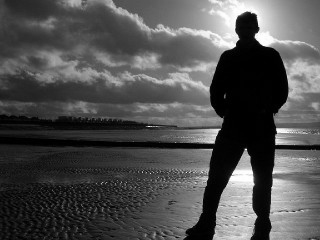

In [62]:
img = img2array("plage.jpeg")

affiche_image(img)

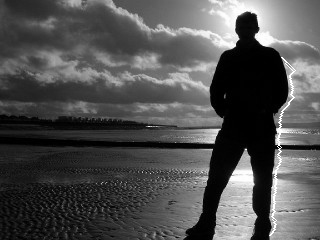

In [64]:
contour(img, (281,57), (269,235), 255)  ##un peu long, c'est normal

affiche_image(img)